# SilverEye Demo 2020-08-25

This page demonstrates how to use the `owslib.wps` Python library to invoke our *SilverEye WPS microservice*. 

In [1]:
from owslib.wps import WebProcessingService
wps = WebProcessingService('https://api.silvereye.bccvl.org.au/wps', verbose=False, skip_caps=True)
wps.getcapabilities()
wps.identification.type

'WPS'

In [2]:
wps.identification.title

'PyWPS Processing Service'

In [3]:
wps.identification.abstract

'PyWPS is an implementation of the Web Processing Service standard from the Open Geospatial Consortium. PyWPS is written in Python.'

In [4]:
for operation in wps.operations:
    print(operation.name)

GetCapabilities
DescribeProcess
Execute


## What processes are supported?

In [5]:
for process in wps.processes:
    print("{:>30}: {}".format(process.identifier, process.title))

   process_one_year_all_months: ANUClim monthly aggregation for all months in one year.
 process_one_year_all_quarters: ANUClim quarterly aggregation for one whole year.
  process_one_year_month_range: ANUClim monthly aggregation within range of months in one year.
    process_one_year_one_month: ANUClim monthly aggregation for one month in one year.
  process_one_year_one_quarter: ANUClim quarterly aggregation for one quarter in one year.
      process_years_all_months: ANUClim monthly aggregation for all months in a range of years.
    process_years_all_quarters: ANUClim quarterly aggregation for a range of years.
       process_years_one_month: ANUClim monthly aggregation for only one month in a range of years.
     process_years_one_quarter: ANUClim quarterly aggregation for one quarter in a range of years.
              process_one_year: ANUClim yearly aggregation for one year.
                 process_years: ANUClim yearly aggregation for a range of years.
process_from_year_month

## Getting Process Descriptions

In [6]:
from owslib.wps import printInputOutput
process = wps.describeprocess('process_one_year_one_month')
process.identifier

'process_one_year_one_month'

In [7]:
process.title

'ANUClim monthly aggregation for one month in one year.'

In [8]:
process.abstract

'Computes a monthly statistical function for env vars at location and time from ANUClimate daily climate grids.'

In [9]:
for input in process.dataInputs:
    printInputOutput(input)
    print()

 identifier=variables, title=Variables to extract, abstract=None, data type=string
 Allowed Value: temp_max
 Allowed Value: temp_min
 Allowed Value: rainfall
 Allowed Value: solar_radiation
 Allowed Value: vapour_pressure
 Default Value: None 
 minOccurs=1, maxOccurs=5

 identifier=stfn, title=Statistical function to apply, abstract=None, data type=string
 Allowed Value: max
 Allowed Value: mean
 Allowed Value: median
 Allowed Value: min
 Allowed Value: std
 Allowed Value: var
 Default Value: None 
 minOccurs=0, maxOccurs=1

 identifier=year, title=Year to process in range 1970:2014, abstract=None, data type=integer
 Default Value: None 
 minOccurs=1, maxOccurs=1

 identifier=month, title=Month to process in range 1:12, abstract=None, data type=integer
 Default Value: None 
 minOccurs=1, maxOccurs=1

 identifier=lat_min, title=Latitude minimum value to process in range -43.735:-9.005, abstract=None, data type=float
 Default Value: None 
 minOccurs=1, maxOccurs=1

 identifier=lat_max, t

In [10]:
for output in process.processOutputs:
    printInputOutput(output)

 identifier=output, title=Metadata, abstract=None, data type=ComplexData
 Supported Value: mimeType=application/zip, encoding=None, schema=None
 Default Value: mimeType=application/zip, encoding=None, schema=None 
 reference=None, mimeType=None


## Understanding SilverEye Processes

At 2020-07-31, Silvereye WPS API includes 39 processes. These processes are divided into 3 spatial selection types, and 13 time selection types.

|Spatial Selection Type|Process Name Prefix ...|Requires Spatial Parameters|
|----------------------|----------------------------|-----------------------------------|
|Rectangular Region|`process_` | `lat_min`, `lat_max`, `lon_min`, `lon_max` |
|Single Location|`process_single_location_` | `lat`, `lon` |
|Predefined Region|`process_predefined_region_`| `gdb_name`, `rec_id`|

The second part of the process name correspond to one of 13 time selection types, and each one is associated with additional time-related parameters.

|Process Name Suffix ...|Associated Parameters|
|--------------------------|---------------------|
|`_one_year_one_month`|`year`, `month`|
|`_one_year_all_months`|`year`|
|`_years_one_month`|`year_min`, `year_max`, `month`|
|`_years_all_months`|`year_min`, `year_max`|
|`_one_year_one_quarter`|`year`, `quarter`|
|`_one_year_all_quarters`|`year`|
|`_years_one_quarter`|`year_min`, `year_max`, `quarter`|
|`_years_all_quarters`|`year_min`, `year_max`|
|`_one_year_month_range`|`year`, `month_min`, `month_max`|
|`_years_month_range`|`year_min`, `year_max`, `month_min`, `month_max`|
|`_from_yrmo_to_yrmo_range`|`year_from`, `month_from`, `year_to`, `month_to`|
|`_one_year`|`year`|
|`_years`|`year_min`, `year_max`|


By combining a process name prefix and a suffix, you have the name of a `processid`.


Next, you need to specify one or more climatic `variables`, from a choice of: `temp_min`, `temp_max`, `rainfall`, `solar_radiation`, `vapour_pressure`.

You also need to specify a statistical function, with the `stfn` parameter name, with a choice of: `min`, `mean`, `median`, `max`, `std` (standard deviation), or `var` (variance).




## Execute a Rectangular Region Process

In [11]:
def monitor_execution(execution, sleepSecs=5, download=False, filepath='data/out.zip'):
    while execution.isComplete() is False:
        execution.checkStatus(sleepSecs=sleepSecs)
        print('Execution status: {}'.format(execution.status))

    if execution.isSucceded():
        if download:
            execution.getOutput(filepath=filepath)
        else:
            for output in execution.processOutputs:
                if output.reference is not None:
                    print('Output URL={}'.format(output.reference))
    else:
        for ex in execution.errors:
            print('Error: code={}, locator={}, text={}'.format(ex.code, ex.locator, ex.text))

The parameters are the following:
- `execution`: the wps process we submitted
- `sleepSecs`: how often to report the status (in seconds)
- `download`: if we want to download the result, then use `filepath`; otherwise, report a URL.
- `filepath`: path to where we want to store the result

If the execution terminated with errors, they will be listed. 

In [12]:
processid = 'process_one_year_one_month'
inputs = [ 
    ("variables", "temp_max"), ("variables", "temp_min"), ("variables", "rainfall"),
    ("stfn", "mean"), 
    ("year", "2014"), ("month", "6"), 
    ("lat_min", "-28.135"), ("lat_max", "-28.105"),
    ("lon_min", "152.855"), ("lon_max", "152.875")
]
output = "OUTPUT"
execution = wps.execute(processid, inputs, output = "OUTPUT")
execution.getStatus()

'ProcessAccepted'

In [14]:
monitor_execution(execution, sleepSecs=20, download=True, filepath='workspace/data/outputs/out20200825T1102.zip')

## Zip Contents

In [15]:
filepath='workspace/data/outputs/out20200825T1102.zip'

In [16]:
from zipfile import ZipFile

f = ZipFile(filepath)
print(f.namelist())
f.close()

['result.zarr', 'metadata.json', 'rainfall.csv', 'temp_min.csv', 'temp_min.tif', 'temp_max.tif', 'rainfall.tif', 'temp_max.csv', 'result.csv', 'result.nc']


### Process NetCDF File

In [19]:
import xarray as xr

with ZipFile(filepath) as z:
    res = z.extract('result.nc', path='workspace/data/outputs/')
xds = xr.load_dataset(res)
xds

<xarray.Dataset>
Dimensions:   (lat: 4, lon: 3, time: 1)
Coordinates:
  * lat       (lat) float64 -28.11 -28.11 -28.12 -28.14
  * lon       (lon) float64 152.9 152.9 152.9
  * time      (time) datetime64[ns] 2014-06-01
Data variables:
    rainfall  (time, lat, lon) float32 0.6808464 0.6700856 ... 0.61339635
    temp_max  (time, lat, lon) float32 21.640259 21.457794 ... 21.940153 22.0892
    temp_min  (time, lat, lon) float32 7.1886106 7.2265573 ... 7.1756883
Attributes:
    geospatial_lat_min:         -28.105
    geospatial_lat_max:         -28.135
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.01
    geospatial_lon_min:         152.855
    geospatial_lon_max:         152.875
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.01
    DOI:                        to be added
    licence_data_access:        These data can be freely downloaded and used
    keywords:                   EARTH SCIENCE > ATMOSPHERE
    summary:        

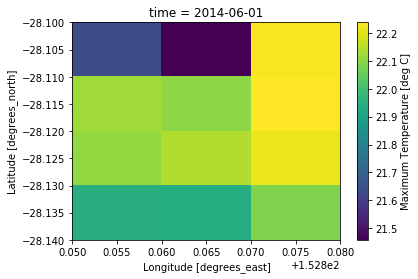

In [21]:
import matplotlib

xds['temp_max'].sel({'time': '2014-06-01'}).plot()

### Process CSV File

In [22]:
import pandas as pd

with ZipFile(filepath) as z:
    with z.open('result.csv') as zf:
        df = pd.read_csv(zf)
df.head()

,lat,lon,time,rainfall,temp_max,temp_min
0,-28.105,152.855,2014-06-01,0.680846,21.640259,7.188611
1,-28.105,152.865,2014-06-01,0.670086,21.457794,7.226557
2,-28.105,152.875,2014-06-01,0.659532,22.230024,7.238303
3,-28.115,152.855,2014-06-01,0.666355,22.126766,7.171170
4,-28.115,152.865,2014-06-01,0.654074,22.104393,7.189524


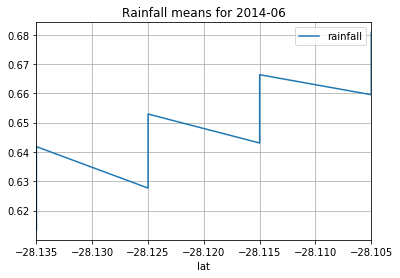

In [23]:
df.plot('lat', 'rainfall', kind='line', title='Rainfall means for 2014-06', grid=True)

### Process Metadata File

In [24]:
import json

with ZipFile(filepath) as z:
    with z.open('metadata.json') as zf:
        data = json.load(zf)
        print(json.dumps(data, indent=4))

{
    "spatial_selection_type": "rectangular_region",
    "process_name": "process_one_year_one_month",
    "variables": [
        "rainfall",
        "temp_max",
        "temp_min"
    ],
    "time_selection": {
        "stfn": "mean",
        "yr": 2014,
        "mo": 6,
        "xly": "monthly"
    },
    "bounds": {
        "lat_min": -28.135,
        "lat_max": -28.105,
        "lon_min": 152.855,
        "lon_max": 152.875
    }
}


### Process TIFF File

In [25]:
import rasterio as rio

with ZipFile(filepath) as z:
    tf = z.extract('temp_max.tif', path='data/outputs')
    rds = rio.open(tf)
        
data = {  # gather all the attrs together
    'meta': rds.meta,
    'bounds': rds.bounds,
    'resolution': rds.res,
    'tags': rds.tags, 
    'indexes': rds.indexes,
    'name': rds.name, 
    'mode': rds.mode
}
data  # notice count: 1, means 1 layer

{'meta': {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': None,
  'width': 3,
  'height': 4,
  'count': 1,
  'crs': CRS.from_dict(init='epsg:4462'),
  'transform': Affine(0.010000000000005116, 0.0, 152.85,
         0.0, -0.010000000000000378, -28.1)},
 'bounds': BoundingBox(left=152.85, bottom=-28.140000000000004, right=152.88, top=-28.1),
 'resolution': (0.010000000000005116, 0.010000000000000378),
 'tags': <function DatasetReader.tags>,
 'indexes': (1,),
 'name': 'data/outputs/temp_max.tif',
 'mode': 'r'}

In [26]:
rds.read(1)

array([[21.640259, 21.457794, 22.230024],
       [22.126766, 22.104393, 22.238274],
       [22.113098, 22.146233, 22.215727],
       [21.950369, 21.940153, 22.0892  ]], dtype=float32)

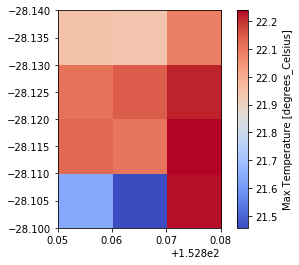

In [27]:
from matplotlib import pyplot
axs = pyplot.imshow(rds.read(1), cmap='coolwarm', origin='lower',
                    extent=(rds.bounds.left, rds.bounds.right, rds.bounds.top, rds.bounds.bottom))
pyplot.colorbar(label='Max Temperature [degrees_Celsius]')
pyplot.show()

## Execute a Single Location Process¶

In [28]:
processid = 'process_single_location_one_year_all_months'
inputs = [
    ("variables", "temp_max"), ("variables", "temp_min"), ("variables", "rainfall"),
    ("stfn", "mean"),
    ("lat", "-28.135"), ("lon", "152.875"),
    ("year", "2014") 
]
output = "OUTPUT"
execution = wps.execute(processid, inputs, output = "OUTPUT")
execution.getStatus()

'ProcessAccepted'

In [29]:
monitor_execution(execution, sleepSecs=30, download=True, filepath='workspace/data/outputs/out20200825T1113.zip')

Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessSucceeded


### Process the NetCDF File

In [32]:
filepath='workspace/data/outputs/out20200825T1113.zip'

In [33]:
import xarray as xr

with ZipFile(filepath) as z:
    res = z.extract('result.nc', path='workspace/data/outputs/')
xds = xr.load_dataset(res)
xds

<xarray.Dataset>
Dimensions:   (time: 12)
Coordinates:
  * time      (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2014-12-01
    lat       float64 -28.14
    lon       float64 152.9
Data variables:
    rainfall  (time) float32 0.72476166 0.12324161 ... 2.4187658 5.6371284
    temp_max  (time) float32 31.622938 31.050322 ... 32.10772 30.764874
    temp_min  (time) float32 18.594612 18.26295 17.146334 ... 17.80273 18.621477
Attributes:
    geospatial_lat_min:         -28.135
    geospatial_lat_max:         -28.135
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.01
    geospatial_lon_min:         152.875
    geospatial_lon_max:         152.875
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.01
    DOI:                        to be added
    licence_data_access:        These data can be freely downloaded and used
    keywords:                   EARTH SCIENCE > ATMOSPHERE
    summary:                    ANU Daily Data Cubes S

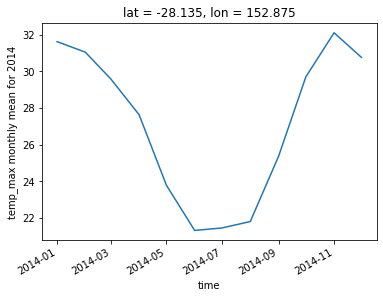

In [34]:
xds['temp_max'].plot()

### Zip File Contents

In [35]:
from zipfile import ZipFile
f = ZipFile(filepath)
print(f.namelist())
f.close()

['temp_min.png', 'rainfall.png', 'metadata.json', 'rainfall.csv', 'temp_min.csv', 'result.png', 'temp_max.csv', 'result.csv', 'result.nc', 'temp_max.png']


### Metadata Results

In [36]:
import json

with ZipFile(filepath) as z:
    with z.open('metadata.json') as zf:
        data = json.load(zf)
        print(json.dumps(data, indent=4))

{
    "spatial_selection_type": "single_location",
    "process_name": "process_single_location_one_year_all_months",
    "variables": [
        "rainfall",
        "temp_max",
        "temp_min"
    ],
    "time_selection": {
        "stfn": "mean",
        "yr": 2014,
        "xly": "monthly"
    },
    "coords": {
        "lat": -28.135,
        "lon": 152.875
    }
}


### Show PNG File

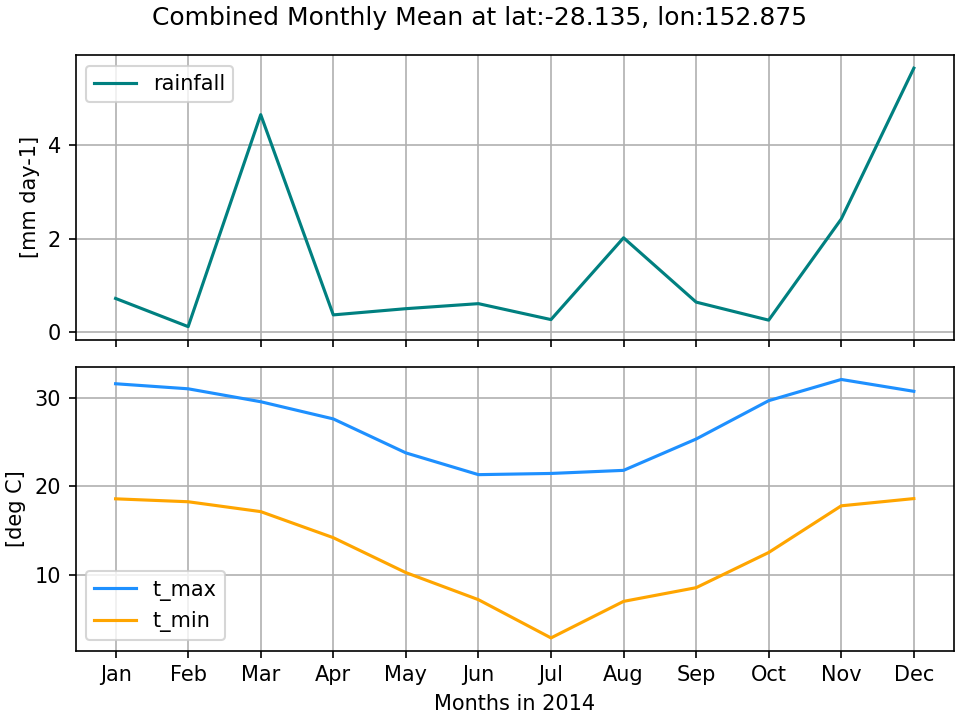

In [37]:
from IPython.display import Image, display

with ZipFile(filepath) as z:
    fp = z.extract('result.png', 'workspace/data/outputs')
    display(Image(fp, width=600, height=400)) 

### CSV Result

In [38]:
import pandas as pd

with ZipFile(filepath) as z:
    with z.open('result.csv') as zf:
        df = pd.read_csv(zf)
df

,time,lat,lon,rainfall,temp_max,temp_min
0,2014-01-01,-28.135,152.875,0.724762,31.622938,18.594612
1,2014-02-01,-28.135,152.875,0.123242,31.050322,18.262950
2,2014-03-01,-28.135,152.875,4.645188,29.586979,17.146334
3,2014-04-01,-28.135,152.875,0.373490,27.641436,14.195909
4,2014-05-01,-28.135,152.875,0.506197,23.794106,10.243060
5,2014-06-01,-28.135,152.875,0.613396,21.331255,7.175688
6,2014-07-01,-28.135,152.875,0.273421,21.467100,2.847722
7,2014-08-01,-28.135,152.875,2.018164,21.816788,6.983506
8,2014-09-01,-28.135,152.875,0.646114,25.364664,8.534827
9,2014-10-01,-28.135,152.875,0.261359,29.705664,12.518283


## Execute a Predefined Region Process

In [39]:
processid = 'process_predefined_region_one_year_month_range'
inputs = [ 
    ("variables", "temp_max"), ("variables", "temp_min"), ("variables", "rainfall"),
    ("stfn", "mean"),
    ("year", "2014"), ("month_min", "4"), ("month_max", "9"), 
    ("gdb_name", "ibra7_subregions_states"), ("rec_id", "347_QLD")
]
output = "OUTPUT"
execution = wps.execute(processid, inputs, output = "OUTPUT")
execution.getStatus()

'ProcessAccepted'

In [44]:
monitor_execution(execution, sleepSecs=20, download=True, filepath='workspace/data/outputs/out20200825T1136.zip')

In [45]:
filepath='workspace/data/outputs/out20200825T1136.zip'

### Zip Contents

In [46]:
from zipfile import ZipFile

f = ZipFile(filepath)
print(f.namelist())
f.close()

['result.zarr', 'metadata.json', 'rainfall.csv', 'temp_min.csv', 'temp_min.tif', 'temp_max.tif', 'rainfall.tif', 'temp_max.csv', 'result.csv', 'result.nc']


### Process the NetCDF Result

In [47]:
import xarray as xr

with ZipFile(filepath) as z:
    res = z.extract('result.nc', path='workspace/data/outputs/') 
xds = xr.load_dataset(res)
xds

<xarray.Dataset>
Dimensions:      (lat: 183, lon: 73, time: 6)
Coordinates:
  * lat          (lat) float64 -28.18 -28.16 -28.16 ... -26.36 -26.36 -26.34
  * lon          (lon) float64 152.8 152.8 152.8 152.9 ... 153.5 153.5 153.5
  * time         (time) datetime64[ns] 2014-04-01 2014-05-01 ... 2014-09-01
    spatial_ref  int32 0
Data variables:
    rainfall     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    temp_max     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    temp_min     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    geospatial_lat_min:         -28.175
    geospatial_lat_max:         -26.335
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.01
    geospatial_lon_min:         152.825
    geospatial_lon_max:         153.545
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.01
    DOI:                        to be added
    licence_data_access:        These 

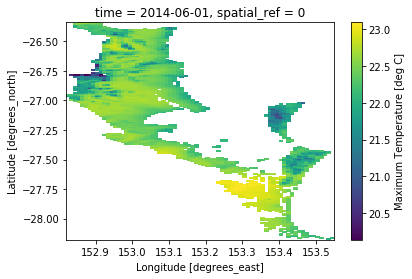

In [48]:

xds['temp_max'].sel({'time': '2014-06-01'}).plot()

### CSV Results

In [55]:
import pandas as pd

with ZipFile(filepath) as z:
    with z.open('result.csv') as zf:
        df = pd.read_csv(zf)
df.head()

,lat,lon,time,spatial_ref,rainfall,temp_max,temp_min
0,-28.175,152.825,2014-04-01,0,NaN,NaN,NaN
1,-28.175,152.825,2014-05-01,0,NaN,NaN,NaN
2,-28.175,152.825,2014-06-01,0,NaN,NaN,NaN
3,-28.175,152.825,2014-07-01,0,NaN,NaN,NaN
4,-28.175,152.825,2014-08-01,0,NaN,NaN,NaN


### Metadata.json

In [56]:
import json

with ZipFile(filepath) as z:
    with z.open('metadata.json') as zf:
        data = json.load(zf)
        print(json.dumps(data, indent=4))

{
    "spatial_selection_type": "predefined_region",
    "process_name": "process_predefined_region_one_year_month_range",
    "variables": [
        "rainfall",
        "temp_max",
        "temp_min"
    ],
    "time_selection": {
        "yr": 2014,
        "mos": [
            4,
            9
        ],
        "xly": "monthly",
        "stfn": "mean"
    },
    "bounds": {
        "lat_min": -28.17702000000003,
        "lat_max": -26.33033062499999,
        "lon_min": 152.81753281,
        "lon_max": 153.55292
    },
    "predefined_region": {
        "rec_id": "347_QLD",
        "sta_code": "QLD",
        "reg_code": "SEQ",
        "reg_name": "South Eastern Queensland",
        "sub_code": "SEQ04",
        "sub_name": "Sunshine Coast-Gold Coast Lowlands",
        "gdb_name": "ibra7_subregions_states"
    }
}


### TIFF File

In [58]:
import rasterio as rio

with ZipFile(filepath) as z:
    tf = z.extract('temp_max.tif', path='workspace/data/outputs')
    rds = rio.open(tf)
        
data = {  # gather all the attrs together
    'meta': rds.meta,
    'bounds': rds.bounds,
    'resolution': rds.res,
    'tags': rds.tags, 
    'indexes': rds.indexes,
    'name': rds.name, 
    'mode': rds.mode
}
data  # notice count: 1, means 1 layer

{'meta': {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': None,
  'width': 73,
  'height': 183,
  'count': 6,
  'crs': CRS.from_dict(init='epsg:4462'),
  'transform': Affine(0.009999999999999985, 0.0, 152.82,
         0.0, 0.010054945054945065, -28.180027472527474)},
 'bounds': BoundingBox(left=152.82, bottom=-26.339972527472526, right=153.54999999999998, top=-28.180027472527474),
 'resolution': (0.009999999999999985, -0.010054945054945065),
 'tags': <function DatasetReader.tags>,
 'indexes': (1, 2, 3, 4, 5, 6),
 'name': 'workspace/data/outputs/temp_max.tif',
 'mode': 'r'}

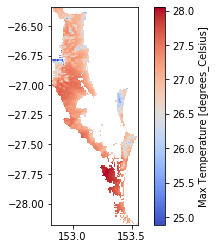

In [59]:
from matplotlib import pyplot
axs = pyplot.imshow(rds.read(1), cmap='coolwarm', origin='lower',
                    extent=(rds.bounds.left, rds.bounds.right, rds.bounds.top, rds.bounds.bottom))
pyplot.colorbar(label='Max Temperature [degrees_Celsius]')
pyplot.show()